# Lab session : Mixture Models

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will apply sklearn's EM on images. You will send only one notebook for both parts.

You have to send the filled notebook named **"GMM_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 19, 2020 and put **"AML-GMM"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from scipy.stats import norm
import random
from sklearn.cluster import KMeans
from collections import defaultdict
from math import sqrt

# GMM Recap

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. 

### If you want to directly go into the code skip the 2 following sections and implement the Update rules

## Context

Let $X$ be a continous random variable that you have observed, it would be nice to estimate the parameters $\theta$ of the theoretical pdf of x i.e $f_X(x;\theta) = p(x|\theta)$. For instance $\theta$ could be a mean or a variance or $f_x$ could be parametrized by many other parameters. To facilitate the estimation of $\theta$ one could introduces latent variables or hidden variables $Y$ which explains X. 

Introducing a latent variable Y which can take K different values one could write $p(x|\theta)$ as a mixture of K distributions : 
$$ p(x|\theta) = \sum_{k=1}^Kp(x,y=y_k|\theta)=\sum_{k=1}^K p(y=y_k|\theta)p(x|y=y_k,\theta)= \sum_{k=1}^K \pi_kf_k(x;\theta_k) $$

## Basic Exemple 

Imagine you are observing the weight of the french population, and you want the theoretical distribution of the weight $f_X(x;\theta)$. You could introduce the sex of the person (discrete latent variable) or the height of the person (continuous latent variable), these 2 latent variables have a deep impact on the weight of the person. We will be looking at the case where Y is discrete.

Let X be the random variable related to the weight of a french person and Y be the sex of the person the pdf of X is given by : 

$$p(x|\theta) = \pi f_1(x)+(1-\pi)f_2(x)$$

$\pi$ is probability to be a man in France, $f_1(x)$ and $f_2(x) $ are respectively the density function of the men's weight and the pdf of the women's weight.

Now we have to estimate $\pi$ and the parameters of $f_1(x)$ and of $f_2(x)$. 

With GMM we assume that $f_k(x;\theta_k)= \mathcal{N}(x |\mu_k,\sigma_k^2)$. Therefore we need to estimate from the observation of X : $\pi,\mu_1,\sigma_1^2,\mu_2,\sigma_2^2$ such as :

$$p(x|\theta) = \pi \mathcal{N}(x |\mu_1,\sigma_1^2)+(1-\pi)\mathcal{N}(x |\mu_2,\sigma_2^2) $$




We generate a fake weight distribution. The EM algorithm will allow us to estimate the parameters of this probability distribution.

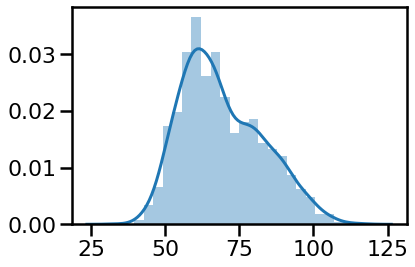

In [2]:

weights = np.append(np.random.normal(60,7,1000),np.random.normal(79,12,1000))
sex = [0 for k in range(1000)]+[1 for k in range(1000)]
sns.distplot(weights)


# EM algorithm 

Em algorithm looks for the parameters $\theta$ maximising :

$$E\left[\mathcal{L}(X_1,...X_N,Y_1,...,Y_N|\theta)|x_1,...x_N,\theta_j\right]= \sum_{i=1}^n \sum_{k=1}^K  \gamma_{i,k}^j \left[ \log(\pi_k) + \log \mathcal{N}(x |\mu_k,\sigma_k^2) \right] == Q(\theta,\theta^j)$$ 

## Update Rules 

Suppose you decide to model your observations $\{x_1,...x_N\}$ with a mixture of K gaussian distributions.

The update rules given by the EM algorithm are at iteration j+1, $k \in \{1,...,K\}$ : 

\begin{align} \gamma_{i,k}^j &= \frac{\pi_k^jf_k(x_i;\theta_k^j)}{\sum_{k=1}^K\pi_k^jf_k(x_i;\theta_k^j)} \\
\pi_k^{j+1} &= \frac{1}{N} \sum_{i=1}^N \gamma_{i,k}^j \\
 (\sigma_k^2)^{j+1}&= \frac{\sum_{i=1}^N (x_i-\mu_k^j)^2\gamma_{i,k}^j}{\sum_{i=1}^N \gamma_{i,k}^j} \\
\mu_k^{j+1}  &= \frac{\sum_{i=1}^N x_i\gamma_{i,k}^j}{\sum_{i=1}^N \gamma_{i,k}^j}
\end{align}

With $\gamma_{i,k}^j = P(Y_i=k|x_i,\theta^j)$ i.e the probability of the data $x_i$ to belong to the class k.

With $f_k(x_i;\theta_k^j) = \mathcal{N}\left(x_i | \mu_k^{j} , (\sigma_k^2)^{j}\right) $

# Task :

- Fill in the following class to implement a 1D-GMM 
- Initialize with Kmeans or with random parameters.

In [3]:
class my_GMM():
    
    def __init__(self, k, nb_iter, init="random"):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.nb_iter_=nb_iter
        self.k_ = k
        
        self.initialization_ = init
        self.mu_ = None
        self.sigma_ = None
        self.pi_ = None
        self.gamma_ = None
        self.labels_ = None
        
        
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        """
        
        mu=[]
        sig=[]
        
        
        def compute_condition_prob_matrix(X, Mu, Sigma):
            
            '''Compute the conditional probability matrix 
            shape: (n, K) i.e p(x|y=k). Use scipy.stats.norm.pdf
            '''
            n = X.shape[0]
            Prob_matrix=np.zeros((n,len(Mu)))
            for j in range (len(Mu)):
                for i in range (n):
                    prob=norm.pdf(X[i], Mu[j], Sigma[j]**2)
                    Prob_matrix[i][j]=prob
   
            return Prob_matrix
            
        
        
        def compute_responsabilities(Condition_prob,pi):
            
            
            '''Compute the responsabilities i.e gamma
            shape: (n, K)
            '''
            n,p=Condition_prob.shape

            gamma = np.zeros((n,p))
            
            for i in range (n):
                total=0
                for k in range (p):
                    repu = pi[k]*Condition_prob[i][k]
                    
                    total+=repu
                    gamma[i][k]=repu
                    
                for k in range (p):
                    gamma[i][k]=gamma[i][k]/total
                    
            return gamma
        
        
    
        K=self.k_
        init=self.initialization_
        pred_init=[]
        
        if (init == "random"):
            for i in range (len(X)):
                pred_init.append(random.randint(0,K-1))
        else:
            X1=X.reshape(len(X),1)
            kmeans_1 = KMeans(n_clusters=K).fit(X1)
            pred_init=kmeans_1.labels_
         
        
        pi_dic=defaultdict(int)
        for i in range (len(pred_init)):
            pi_dic[pred_init[i]]+=1
        
        pi=[]
        for e in pi_dic.keys():
            pi.append(pi_dic[e]/len(pred_init))
            
            
        d=defaultdict(list)
        for i in range (len(pred_init)):
            d[pred_init[i]].append(X[i])
        
        for e in d.keys():
            m=np.mean(d[e],axis=0)
            sg=(np.array(d[e])).var(0)
            mu.append(m)
            sig.append(sg)
        
        itera =0
        while (itera<self.nb_iter_):
            
          
            pmatrix = compute_condition_prob_matrix(X, mu, sig)
            gamma = compute_responsabilities(pmatrix,pi)
            

            
            for k in range (len(pi)):
                summ=0
                for i in range (len(X)):
                    summ+=gamma[i][k]
                pi[k]=summ/len(X)
                
                    
                    
                
                
                
            for k in range (len(sig)):
                sg=0
                summ=0
                for i in range (len(X)):
                    sg+=((X[i]-mu[k])**2)*gamma[i][k]
                    summ+=gamma[i][k]
                sg=sg/summ
                sig[k]=sqrt(sg)
            
            for k in range (len(mu)):
                m=0
                summ=0
                for i in range (len(X)):
                    m+=X[i]*gamma[i][k]
                    summ+=gamma[i][k]
                    
                m=m/summ
                mu[k]=m    
            itera+=1
        
    

        self.mu_ = mu
        self.sigma_ = sig
        self.pi_ = pi
        self.gamma_ = gamma
        
        
        label=[]
        for i in range (len(X)):
            clust=np.argmax(pmatrix[i])
            label.append(clust)
        self.labels_ = label

        
        
        
        
        
        
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
         
        n = X.shape[0]
        
        Mu=self.mu_
        Sigma=self.sigma_
        pi=self.pi_
        
        Prob_matrix=np.zeros([n,len(Mu)])
        for j in range (len(Mu)):
            for i in range (n):
                  
                prob=norm.pdf(X[i], Mu[j], Sigma[j]**2)
                
                Prob_matrix[i][j]=prob                    
    
    
        gamma = np.zeros((n,len(Mu)))
        for i in range (n):
            total=0
            for k in range (len(Mu)):
                repu = pi[k]*Prob_matrix[i][k]
                
                total+=repu
                gamma[i][k]=repu
            
            for k in range (len(Mu)):
                    gamma[i][k]=gamma[i][k]/total
        return gamma
            
        
        
            
        
       
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        label=[]
        
        prob_matrix = self.predict_proba(X)
        for i in range(len(X)):
            clust=np.argmax(prob_matrix[i])
            label.append(clust)
        
        return label
   


## Task : 

Apply you EM algorithm to the weights array.

What is the average weight for a man ? What is the average weight for a woman ? 
What are the standard deviations ? 

In [4]:
gmm = my_GMM(2,10,init='Kmeans')

gmm.fit(weights)

print('mu',gmm.mu_)
print('sigma',gmm.sigma_)


NameError: name 'my_GMM' is not defined

# Task :
- Predict the sex of the persons thanks to their weight. 
- Compute the accuracy (the ground truth is the sex list)
- Compare with the accuracy of a kmeans

## Application - Generating Images

The goal of this exercice is to make your computer learn how to write digits.

Actually we are going to apply EM algorithm to digits and sample fake data from the model returned (i.e $p(x|\theta)$)

(2500, 784)


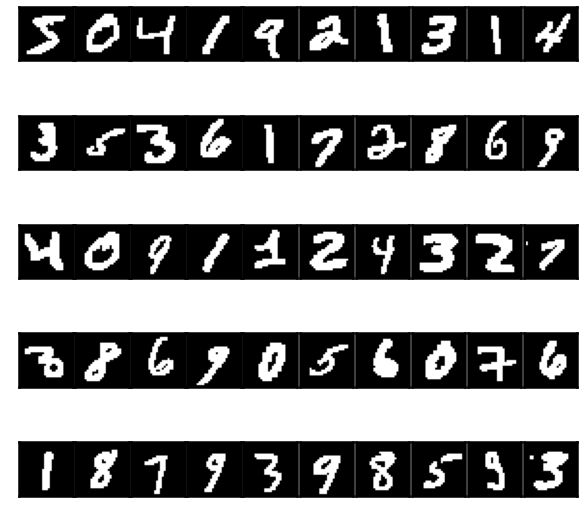

In [5]:
data = np.loadtxt('mnist2500_X.txt')


import matplotlib.pyplot as plt

size=28

def plot_digits(data, size):
    fig, ax = plt.subplots(5, 10, figsize=(10, 10),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.01, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(size, size).T, cmap='binary')
        #im.set_clim(0, )
plot_digits(data,size)
print(data.shape)

### Tasks : 
- Model your data with the GMM model from sklearn and produce new synthetic handwritten numbers. 
Use : 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

use the .sample() method from sklearn's GaussianMixture to generate fake samples


In [57]:
from sklearn.mixture import GaussianMixture as GMM

model =GMM(50,covariance_type='full', random_state=0)

model.fit(data)
print(model.converged_)

True


(250, 784)


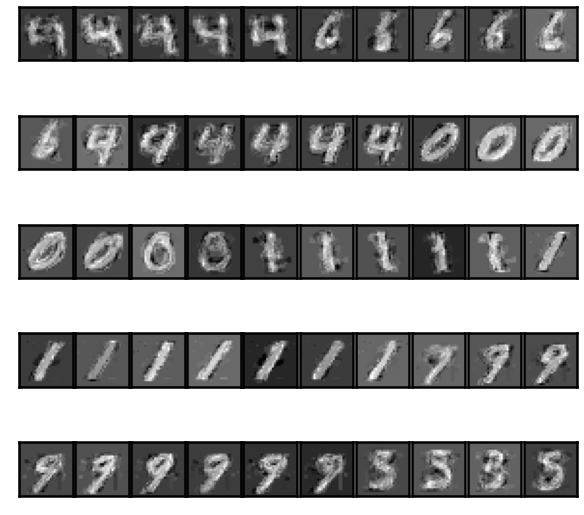

In [58]:
new_data=model.sample(250)
print(new_data[0].shape)
plot_digits(new_data[0],size)


### Tasks :
- Use a method you saw in your previous courses to reduce the dimension of our dataset.
- Model your data with the GMM model from sklearn and produce new synthetic handwritten numbers. 
- Compare results

In [59]:
from sklearn.decomposition import NMF

nmf=NMF(n_components=25,random_state=0)
red_data = nmf.fit_transform(data)
red_data.shape


C:\Users\theoc\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


(2500, 25)

In [60]:
model2 =GMM(50,covariance_type='full', random_state=0)

model2.fit(red_data.component)
print(model2.converged_)

True


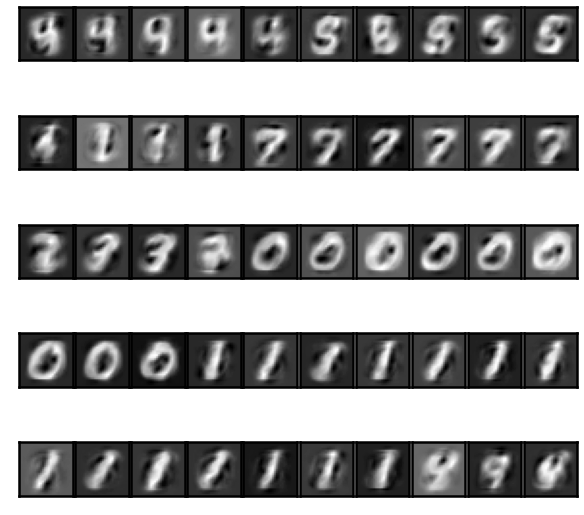

In [61]:
new_data1=model2.sample(250)
dgit_numb =nmf.inverse_transform(new_data1[0])
plot_digits(dgit_numb,28)

In [ ]:
#the first results, the handwritten numbers are clearly visible even if somme number can be 
#confused ( ex :4 or 9, 7 or 9, 3 or 5...)

#the second results are more blurry but we still can read some numbers ( easy to recognise 0,1 or 7 ) but there is more 
#confused number du to the blurry( 3 or 0 , 5 or 0)
